# Notebook for Project 3: An experiment for temparture and water influence on chamomile flowers
-- Parijat, Jiwoo, Yue, Jiaxun


## Experiment setup

## Analysis Overview

In this project,  we performed two analyses to understand the relationship between chamomile freshness and environmental conditions, one based on "objective" views: the color value from the pictures of the flowers, another based on "subjective" views: blinded survey from different people rating the freshness of chamomiles.

1. **HSV based analysis**
   - Extracte **HSV color values** from flower images over five consecutive days.  
   - Explore how **Saturation (S)** and **Value (V)** changed under different water and temperature conditions, calculate the freshness value based on these two variables.  
   - Fit a linear model and do a permutation test based on the freshness value calculated above.

2. **Human-Evaluated Survival Time**
   - Collect survey data on how many days each flower remained visibly “fresh”. People need to rate how fresh a flower is: from 0 to 5 from the picture of the flower, without knowing the condition of the flower.
   - ?????? TBD

More details of the two analysis are provided below.

### HSV based analysis

#### 1. Measuring Freshness from Images

**Goal:** Quantify how fresh each flower looks over time using color information.

**Step 1 — Normalization.** Adjust brightness to reduce lighting differences across photos.

**Step 2 — Detect Flower & Extract Color.** Isolate petals and compute average **RGB/HSV** values per image.





In [ ]:
# Code TBD 

**Step 3 — Freshness Metric (HSV).** Use **Saturation** $S$ and **Value** $V$ to define a log‑ratio freshness score:

$$
\log F \,=\, \tfrac{1}{2}\,\log\!\left(\frac{S}{S_{\max}}\right)\; +\; \tfrac{1}{2}\,\log\!\left(\frac{V}{V_{\max}}\right),
$$

where $S_{\max}$ and $ V_{\max}$ are the maximum observed values used for scaling. This construction increases when saturation/value are high and decreases as the flower fades.

In [16]:
# ============================================
# Hue-free freshness modeling pipeline
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# === 1. Load HSV data ===
S_wide = pd.read_csv("./Analysis_HSV/HSV_S.csv")
V_wide = pd.read_csv("./Analysis_HSV/HSV_V.csv")

S_wide.columns = [c.strip().lower() for c in S_wide.columns]
V_wide.columns = [c.strip().lower() for c in V_wide.columns]
id_col = "image_number"
day_cols = [c for c in S_wide.columns if c.startswith("day")]

#| group | condition              |
#| ----- | ---------------------- |
#| 1     | low temp + with water  |
#| 2     | room temp + with water |
#| 3     | low temp + no water    |
#| 4     | room temp + no water   |

group_assign = pd.DataFrame({
    'image_number':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                           'group':[3,1,2,4,2,3,2,1,3,1,4,3,2,4,4,1]
                           })
S_wide = S_wide.merge(group_assign, on='image_number', how='left')

# === 2. Wide → long and merge ===
S_long = S_wide.melt(id_vars=[id_col,"group"], value_vars=day_cols,
                     var_name="day_label", value_name="S")
V_long = V_wide.melt(id_vars=[id_col], value_vars=day_cols,
                     var_name="day_label", value_name="V")

S_long["day"] = S_long["day_label"].str.extract(r"(\d+)").astype(int)
V_long["day"] = V_long["day_label"].str.extract(r"(\d+)").astype(int)
S_long = S_long.drop(columns=["day_label"])
V_long = V_long.drop(columns=["day_label"])
S_long = S_long.query("day >= 1")
V_long = V_long.query("day >= 1")

df = pd.merge(S_long, V_long, on=[id_col,"day"], how="outer")


df = pd.merge(S_long, V_long, on=[id_col,"day"], how="outer")
# === 3. Map groups to conditions ===
group_map = {
    1: ("low","yes"),
    2: ("room","yes"),
    3: ("low","no"),
    4: ("room","no")
}
df["temp"]  = df["group"].map(lambda g: group_map.get(g,(np.nan,np.nan))[0])
df["water"] = df["group"].map(lambda g: group_map.get(g,(np.nan,np.nan))[1])

# === 4. Normalize and compute freshness ===
df["S"] = pd.to_numeric(df["S"], errors="coerce")


df["V"] = pd.to_numeric(df["V"], errors="coerce")

base = df.groupby(id_col)[["S","V"]].max().rename(columns={"S":"Sbase","V":"Vbase"})
df = df.merge(base, on=id_col, how="left")

df["s"] = ((df["S"])/(df["Sbase"])).clip(1e-6,1.0)
df["v"] = ((df["V"])/(df["Vbase"])).clip(1e-6,1.0)
df["F"] = np.sqrt(df["s"] * df["v"])
df["logF"] = np.log(df["F"])

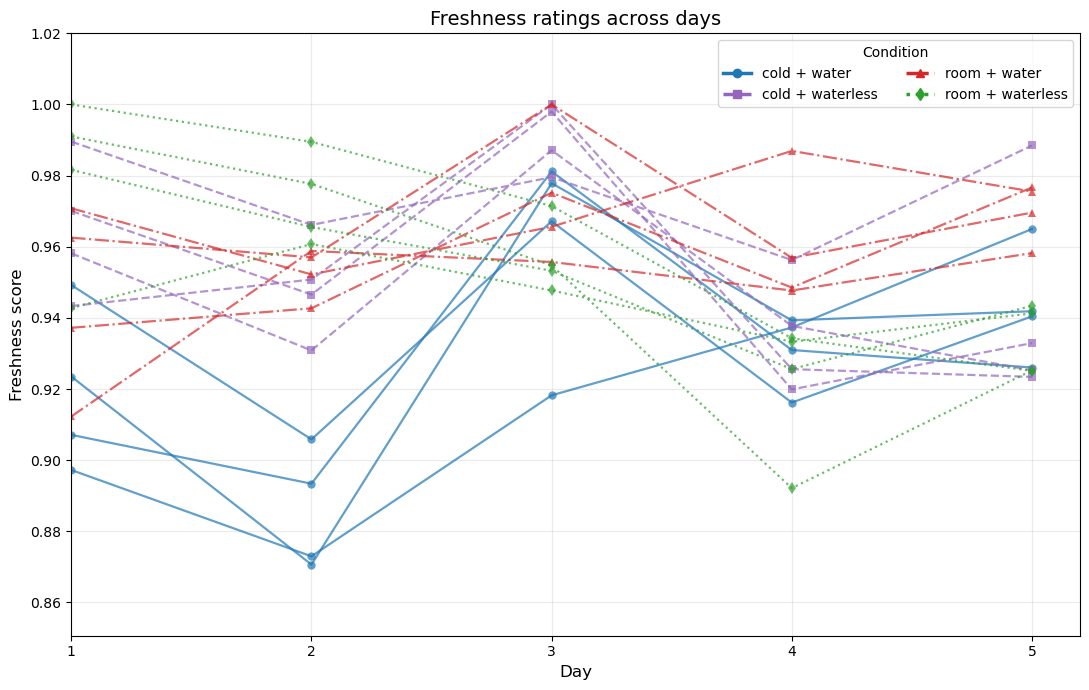

In [17]:
# === Individual freshness by group (with consistent color per group) ===
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def cond_label(t, w):
    temp_name = "cold" if t == "low" else "room"
    water_name = "water" if w == "yes" else "waterless"
    return f"{temp_name} + {water_name}"

df_plot = df.dropna(subset=["F", "day", "temp", "water"]).copy()
df_plot["condition"] = df_plot.apply(lambda r: cond_label(r["temp"], r["water"]), axis=1)

# 1. Assign fixed color per condition
color_map = {
    "cold + water":     "#1f77b4",  # blue
    "cold + waterless": "#9467bd",  # purple
    "room + water":     "#d62728",  # red
    "room + waterless": "#2ca02c",  # green
}

# 2. Style map: same as before
style_map = {
    "cold + water":     {"linestyle": "-",  "marker": "o"},
    "cold + waterless": {"linestyle": "--", "marker": "s"},
    "room + water":     {"linestyle": "-.", "marker": "^"},
    "room + waterless": {"linestyle": ":",  "marker": "d"},
}

# 3. Plot# === Plot individual freshness lines only, same color within each group ===
plt.figure(figsize=(11, 7))

for cond, g in df_plot.groupby("condition"):
    color = color_map[cond]
    for fid, gi in g.groupby("image_number"):
        gi = gi.sort_values("day")
        plt.plot(
            gi["day"], gi["F"],
            linestyle=style_map[cond]["linestyle"],
            marker=style_map[cond]["marker"],
            color=color,
            linewidth=1.6,
            alpha=0.7,          # uniform brightness
            markerfacecolor=color,
            markeredgewidth=0
        )

plt.xlabel("Day", fontsize=12)
plt.ylabel("Freshness score", fontsize=12)
plt.title("Freshness ratings across days", fontsize=14)
plt.xticks(sorted(df_plot["day"].unique()))
plt.grid(True, alpha=0.25)

# Start from day 1 and fit y-axis
plt.xlim(1, df_plot["day"].max() + 0.2)
plt.ylim(df_plot["F"].min() - 0.02, df_plot["F"].max() + 0.02)

# Legend (one per condition)
handles = [
    Line2D([0], [0],
           linestyle=style_map[k]["linestyle"],
           marker=style_map[k]["marker"],
           color=color_map[k],
           linewidth=2.5, label=k)
    for k in style_map
]
plt.legend(handles=handles, title="Condition", ncol=2, frameon=True)

plt.tight_layout()
plt.show()



#### 2. Linear Mixed Model

We relate freshness to day, water, and temperature (and their interactions), allowing **random intercept and slope per flower**:
$$
\log F_{it}
= \beta_0 + \beta_1\,\text{Day}_t + \beta_2 W_i + \beta_3\,(\text{Day}_t \times W_i)
+ \beta_4 T_i + \beta_5\,(\text{Day}_t \times T_i)
+ \beta_6 (W_i \times T_i) + \beta_7 (\text{Day}_t \times W_i \times T_i)
+ b_{0i} + b_{1i}\,\text{Day}_t + \varepsilon_{it}.
$$

where we use the following factor and notations

- **Time ($\text{Day}_t$):** days $t = 1,\dots,5$.  
- **Water condition ($W_i$):** 1 = with water, 0 = no water.  
- **Temperature ($T_i$):** 1 = low temperature, 0 = room temperature.  
- **Freshness ($F_{it}$):** computed as above for flower $i$ on day $t$.

- **Random effects:**  
  - $b_{0i}$: random intercept (baseline freshness varies across flowers).  
  - $b_{1i}$: random slope for **Day** (decay rate varies across flowers).

- **Interpretation of key fixed effects:**  
  - $\beta_1$: average day‑to‑day freshness change.  
  - $\beta_2$: baseline difference for **with vs. without water**.  
  - $\beta_3$: difference in the **day trend** when water is present.  
  - $\beta_4$: baseline difference for **low vs. room temperature**.  
  - Higher‑order terms capture combined effects.

From the result below, we can see that there are only two parameters that are siginifant: $\beta_1$ and $\beta_3$. $\beta_1$ is significant below 0, which means that the chamomile's freshness drop every day. $\beta_3$ is significant above 0, which means that chamomile's freshness drop slower when water is present.

In [12]:
# ===  Fit mixed-effects model ===
df["temp_code"] = df["temp"].map({"room":0,"low":1})
df["water_code"] = df["water"].map({"no":0,"yes":1})

mdl_df = df.dropna(subset=["logF","day","temp_code","water_code"]).copy()
mdl_df["day"] = mdl_df["day"].astype(float)

model = smf.mixedlm("logF ~ day*water_code*temp_code",
                    mdl_df, groups=mdl_df["image_number"],
                    re_formula="~ day")
fit = model.fit(method="lbfgs")
print(fit.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     logF    
No. Observations:      80          Method:                 REML    
No. Groups:            16          Scale:                  0.0006  
Min. group size:       5           Log-Likelihood:         150.8195
Max. group size:       5           Converged:              No      
Mean group size:       5.0                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -0.004    0.016 -0.258 0.796 -0.035  0.027
day                      -0.015    0.004 -3.454 0.001 -0.023 -0.006
water_code               -0.054    0.022 -2.446 0.014 -0.097 -0.011
day:water_code            0.021    0.006  3.406 0.001  0.009  0.033
temp_code                -0.022    0.022 -0.994 0.320 -0.065  0

/usr/local/anaconda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.130759
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)




#### 4. Permutation Test Design

We test **treatment contrasts** using the day‑1 to day‑5 freshness change $\Delta_i = F_{i,5} - F_{i,1}$.

**Water effect within a temperature stratum:**  
- Compare $\Delta$ for *with water* vs *no water* **within low temperature**, permuting the water labels **only within low‑temp flowers**.  
- Repeat **within room temperature**.

**Temperature effect within a water stratum:**  
- Compare $\Delta$ for *low temp* vs *room temp* **within with‑water**, permuting temperature labels **within with‑water flowers**.  
- Repeat **within no‑water**.

For each contrast, the **permutation $p$-value** is the fraction of permutations whose test statistic (group mean difference of $\Delta$) is at least as extreme as observed.

From the anlysis below, we can see that in both *low temp* and *room temp* groups, water availablity makes a siginifant difference to freshness for chamomile flowers. However, temprature seems does not have a significant difference to freshness in both *with water* and *no water* groups

In [ ]:
# ============================================
# Permutation test on day1–day5 freshness change
# ============================================

# --- \Delta F = F(day5) − F(day1) per flower ---
df["day"] = df["day"].astype(int)
delta = (
    df.pivot_table(index="image_number", columns="day", values="F")
    .assign(diff=lambda x: x[5] - x[1])
    .reset_index()[["image_number","diff"]]
)
delta = delta.merge(group_assign, on="image_number", how="left")
delta["temp"]  = delta["group"].map(lambda g: group_map[g][0])
delta["water"] = delta["group"].map(lambda g: group_map[g][1])

# =======================================================
#  (A) Water effect: within each temperature
# =======================================================
obs_water = {}
perm_pvals_water = {}
n_perm = 10000

for temp in ["low","room"]:
    sub = delta[delta["temp"]==temp]
    obs_diff = sub[sub["water"]=="yes"]["diff"].mean() - sub[sub["water"]=="no"]["diff"].mean()
    obs_water[temp] = obs_diff

    diffs = []
    for _ in range(n_perm):
        shuffled = sub.copy()
        shuffled["water"] = np.random.permutation(shuffled["water"].values)
        m_yes = shuffled[shuffled["water"]=="yes"]["diff"].mean()
        m_no  = shuffled[shuffled["water"]=="no"]["diff"].mean()
        diffs.append(m_yes - m_no)
    diffs = np.array(diffs)
    pval = (np.sum(diffs >= obs_diff) + 1) / (len(diffs) + 1)
    perm_pvals_water[temp] = pval

# =======================================================
#  (B) Temperature effect: within each water condition
# =======================================================
obs_temp = {}
perm_pvals_temp = {}

for water in ["yes","no"]:
    sub = delta[delta["water"]==water]
    obs_diff = sub[sub["temp"]=="low"]["diff"].mean() - sub[sub["temp"]=="room"]["diff"].mean()
    obs_temp[water] = obs_diff

    diffs = []
    for _ in range(n_perm):
        shuffled = sub.copy()
        shuffled["temp"] = np.random.permutation(shuffled["temp"].values)
        m_low  = shuffled[shuffled["temp"]=="low"]["diff"].mean()
        m_room = shuffled[shuffled["temp"]=="room"]["diff"].mean()
        diffs.append(m_low - m_room)
    diffs = np.array(diffs)
    pval = (np.sum(diffs >= obs_diff) + 1) / (len(diffs) + 1)
    perm_pvals_temp[water] = pval

# =======================================================
#  Combine & report
# =======================================================

print("\nObserved water effects (with - no water):", obs_water)
print("Permutation p-values (water effects):", perm_pvals_water)
print("\nObserved temperature effects (low - room):", obs_temp)



Observed water effects (with - no water): {'low': 0.04682471047294384, 'room': 0.06937111365079038}
Permutation p-values (water effects): {'low': 0.031996800319968, 'room': 0.014098590140985901}

Observed temperature effects (low - room): {'yes': -0.00022880941171715685, 'no': 0.02231759376612938}
Permutation p-values (temperature effects): {'yes': 0.5164483551644835, 'no': 0.11388861113888611}

Minimum empirical p-value across all tests = 0.014098590140985901


### Survey based analysis

## Conclusion


- **Water access** has the most substantial influence on the freshness of Chamomile flowers across all analyses.  
- **Low temperature** conditions slow down the deterioration process, especially when water is unavailable.  
- The results from both the **color-based analysis** and **human evaluation** are consistent, reinforcing the reliability of the findings.

## Challenges and Future Directions

- The **experiment duration (5 days)** is relatively short; a longer observation window could reveal nonlinear decay patterns.  
- In the **low-temperature setup**, restricted air circulation may serve as a potential confounding factor.  
- Future work should explore **more objective and comprehensive freshness measurements**, integrating spectral, morphological, and biochemical features.
